## Background Information about the data

Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available. This dataset contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months).

In [97]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Dropout
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [98]:
df = pd.read_csv('household_power_consumption.txt', sep=';', parse_dates={'dt':['Date','Time']}, infer_datetime_format=True,
                low_memory=False, na_values=['nan','?'], index_col='dt')
df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0


In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [100]:
df.index.duplicated().sum()

0

In [101]:
df.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [102]:
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [103]:
df.loc[df['Global_active_power'].isnull()].head(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-21 11:23:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-21 11:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
df = df.interpolate(method='linear')
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [105]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.090280e+00,1.236492e-01,2.408328e+02,4.621481e+00,1.109485e+00,1.289229e+00,6.442386e+00
std,1.052628e+00,1.124194e-01,3.237763e+00,4.424361e+00,6.115843e+00,5.786613e+00,8.415860e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.100000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.140000e-01,1.000000e-01,2.410000e+02,2.751585e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428700e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


### Visualization

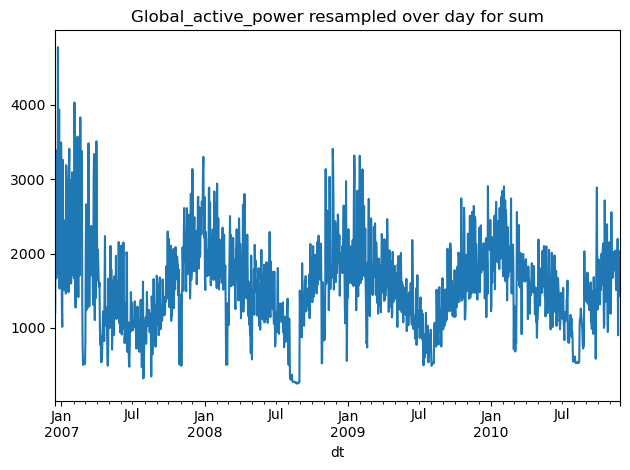

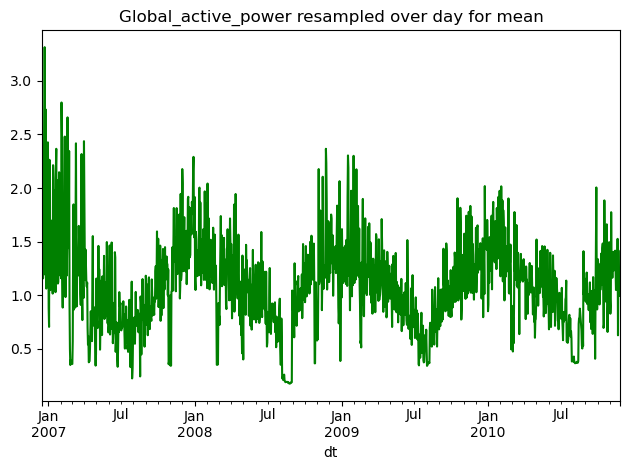

In [106]:
#from per min to per day (resampling)
df.Global_active_power.resample('D').sum().plot(title='Global_active_power resampled over day for sum') 
plt.tight_layout()
plt.show()   

df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day for mean', color='green') 
plt.tight_layout()
plt.show()

It can observed that mean and sum of resampled data set have similar structure.

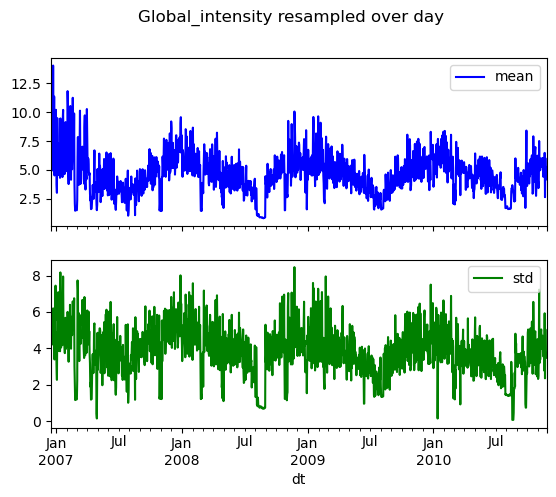

In [107]:
### Below I show mean and std of 'Global_intensity' resampled over day 
r = df.Global_intensity.resample('D').agg(['mean', 'std'])
r.plot(subplots = True, title='Global_intensity resampled over day', color=['blue','green'])
plt.show()

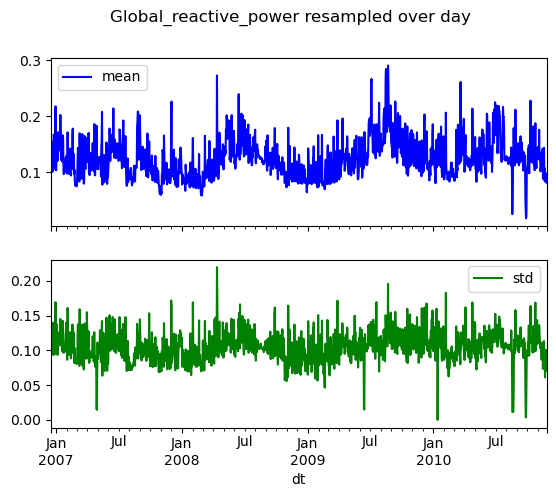

In [108]:
### Below I show mean and std of 'Global_reactive_power' resampled over day
r2 = df.Global_reactive_power.resample('D').agg(['mean', 'std'])
r2.plot(subplots = True, title='Global_reactive_power resampled over day',color=['blue','green'])
plt.show()

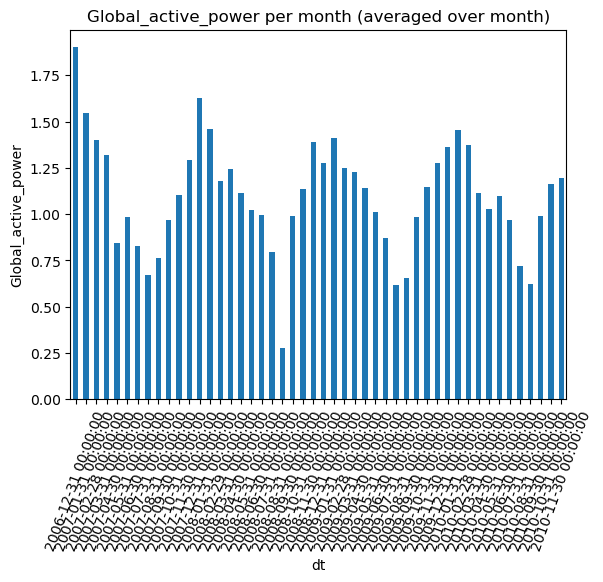

In [109]:
# Sum of 'Global_active_power' resampled over month
df['Global_active_power'].resample('M').mean().plot(kind='bar')
plt.xticks(rotation=70)
plt.ylabel('Global_active_power')
plt.title('Global_active_power per month (averaged over month)')
plt.show()

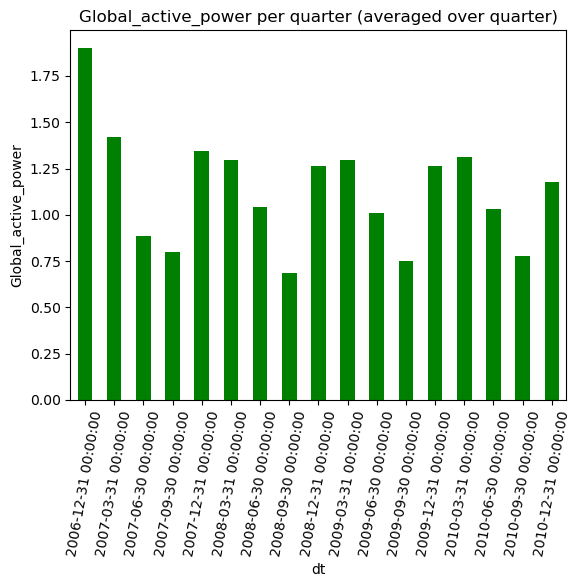

In [110]:
## Mean of 'Global_active_power' resampled over quarter
df['Global_active_power'].resample('Q').mean().plot(kind='bar', color='green')
plt.xticks(rotation=80)
plt.ylabel('Global_active_power')
plt.title('Global_active_power per quarter (averaged over quarter)')
plt.show()

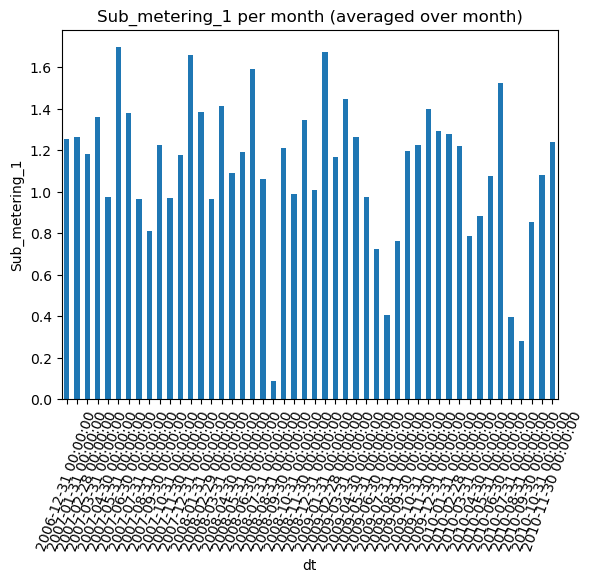

In [111]:
df['Sub_metering_1'].resample('M').mean().plot(kind='bar')
plt.xticks(rotation=70)
plt.ylabel('Sub_metering_1')
plt.title('Sub_metering_1 per month (averaged over month)')
plt.show()

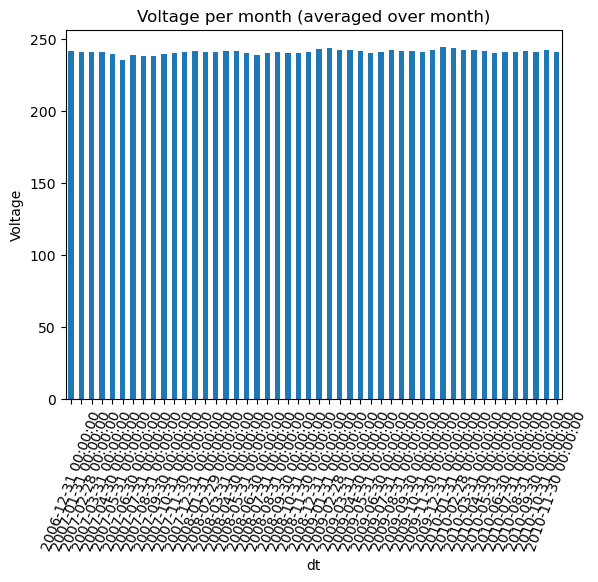

In [112]:
# mean of 'Voltage' resampled over month
df['Voltage'].resample('M').mean().plot(kind='bar')
plt.xticks(rotation=70)
plt.ylabel('Voltage')
plt.title('Voltage per month (averaged over month)')
plt.show()

The mean of 'Volage' over month is pretty much constant compared to other features.

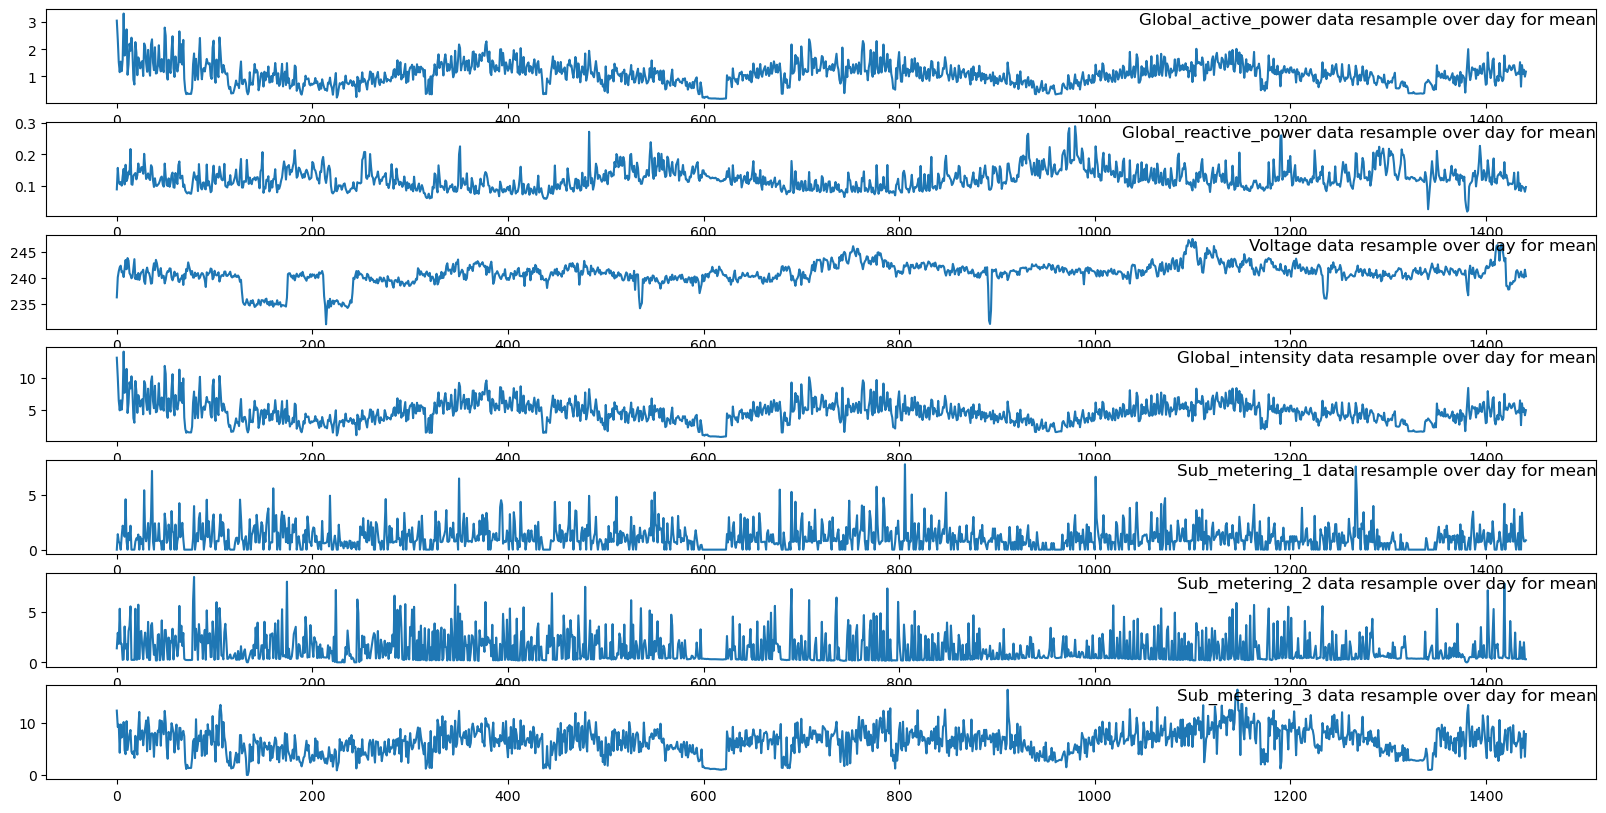

In [113]:
# Below I compare the mean of different features resampled over day. 
i = 1
cols=[0, 1, 2, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('D').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over day for mean', y=0.75, loc='right')
    i += 1
plt.show()

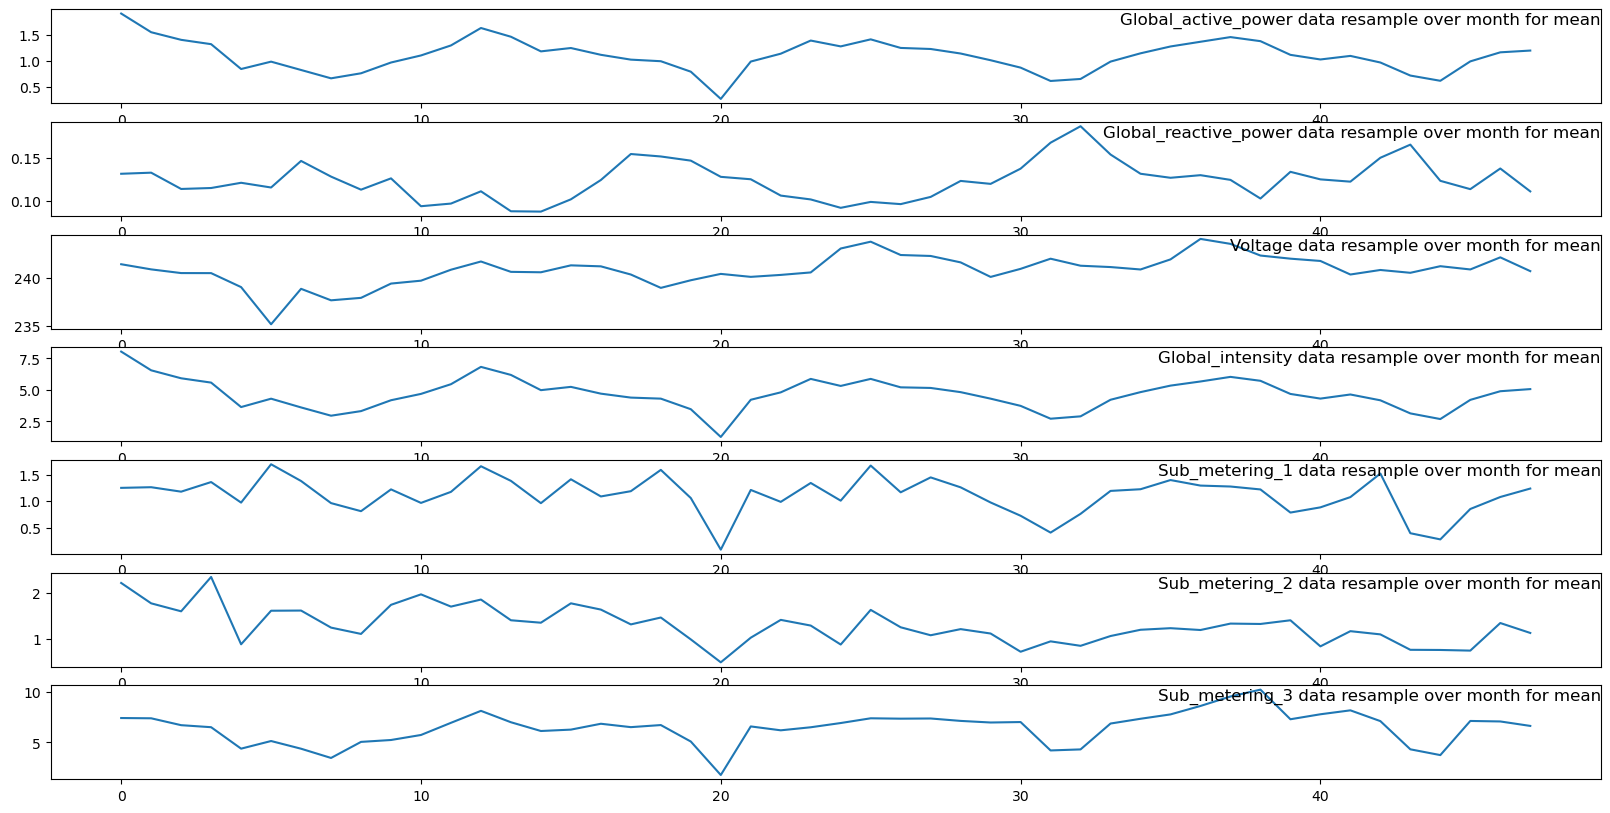

In [115]:
# Below I compare the mean of different features resampled over month. 
i = 1
cols=[0, 1, 2, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('M').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over month for mean', y=0.75, loc='right')
    i += 1
plt.show()

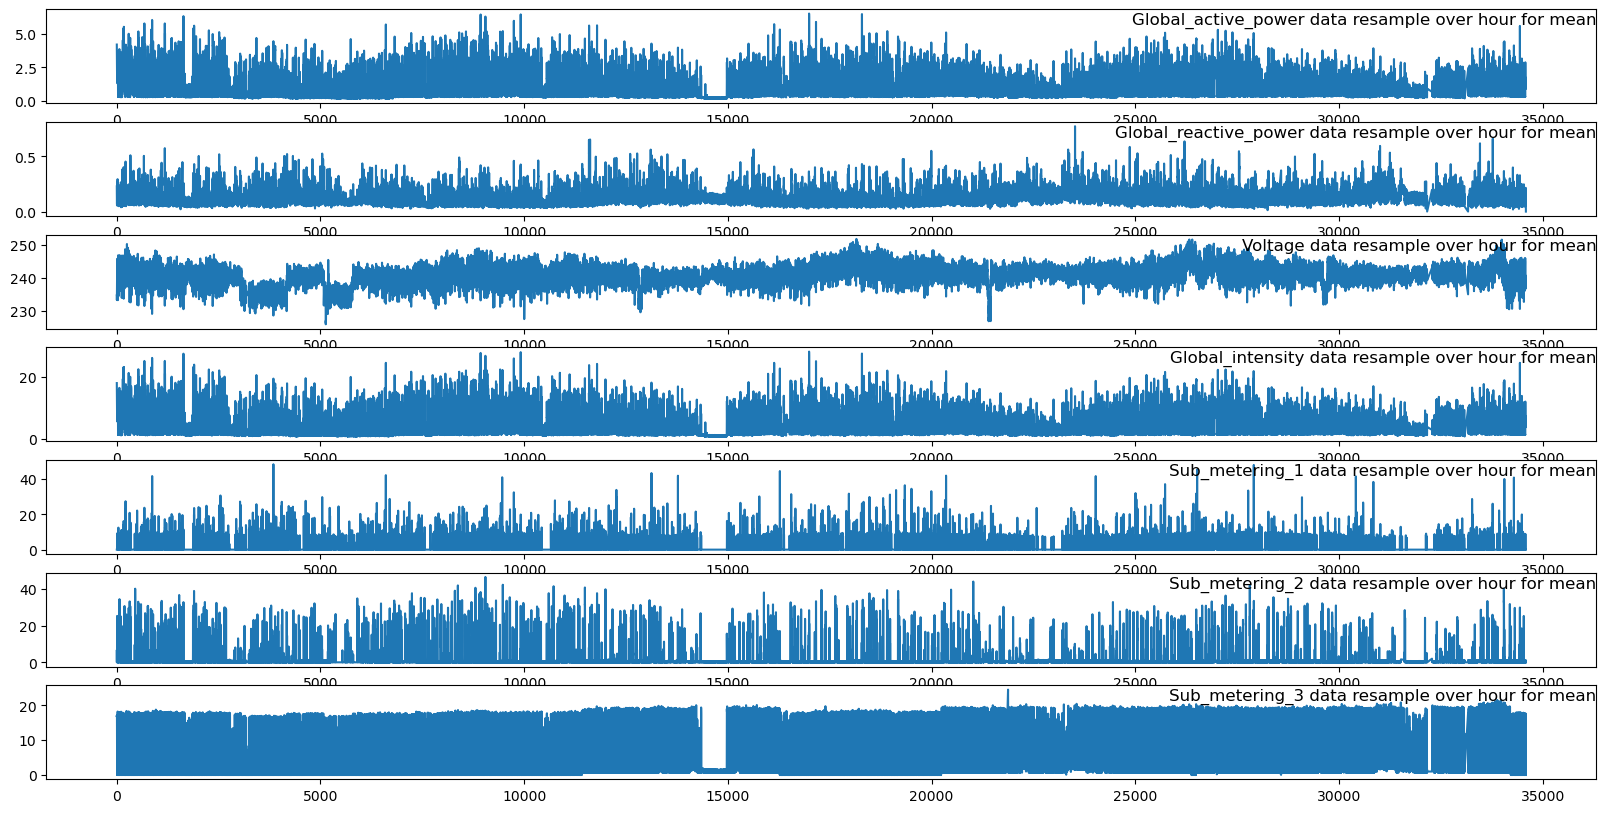

In [116]:
i = 1
cols=[0, 1, 2, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('H').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over hour for mean', y=0.75, loc='right')
    i += 1
plt.show()

- Resampling by month, day or hour is very important because it has a large impacts (changing the periodicity of the system).
- But, if processing all the original data, the runtime will be very costly. Again, If I process the data with large time-scale samples (e.g. monthly), it will affect the model's predictivity.
- From observation, we can see, it is relatively reasonable to resample data by hour.

In [117]:
df.corr()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.245047,-0.395522,0.998887,0.483816,0.433892,0.639272
Global_reactive_power,0.245047,1.000000,-0.109030,0.264162,0.122743,0.139204,0.087743
Voltage,-0.395522,-0.109030,1.000000,-0.407198,-0.194100,-0.165348,-0.265510
Global_intensity,0.998887,0.264162,-0.407198,1.000000,0.488756,0.439713,0.627264
Sub_metering_1,0.483816,0.122743,-0.194100,0.488756,1.000000,0.055011,0.102704
Sub_metering_2,0.433892,0.139204,-0.165348,0.439713,0.055011,1.000000,0.080710
Sub_metering_3,0.639272,0.087743,-0.265510,0.627264,0.102704,0.080710,1.000000


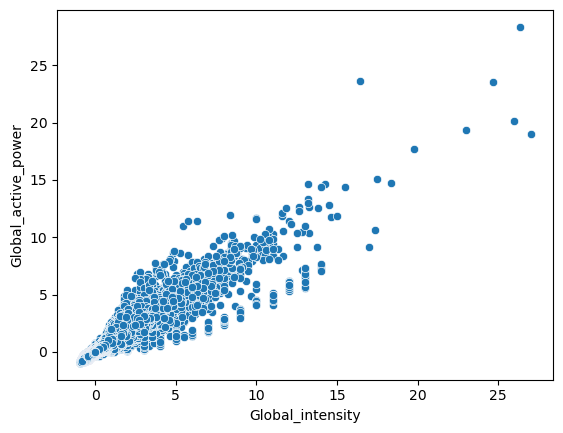

In [118]:
# The correlations between 'Global_intensity', 'Global_active_power'
data_returns = df.pct_change()
sns.scatterplot(x='Global_intensity', y='Global_active_power', data=data_returns)  

plt.show()

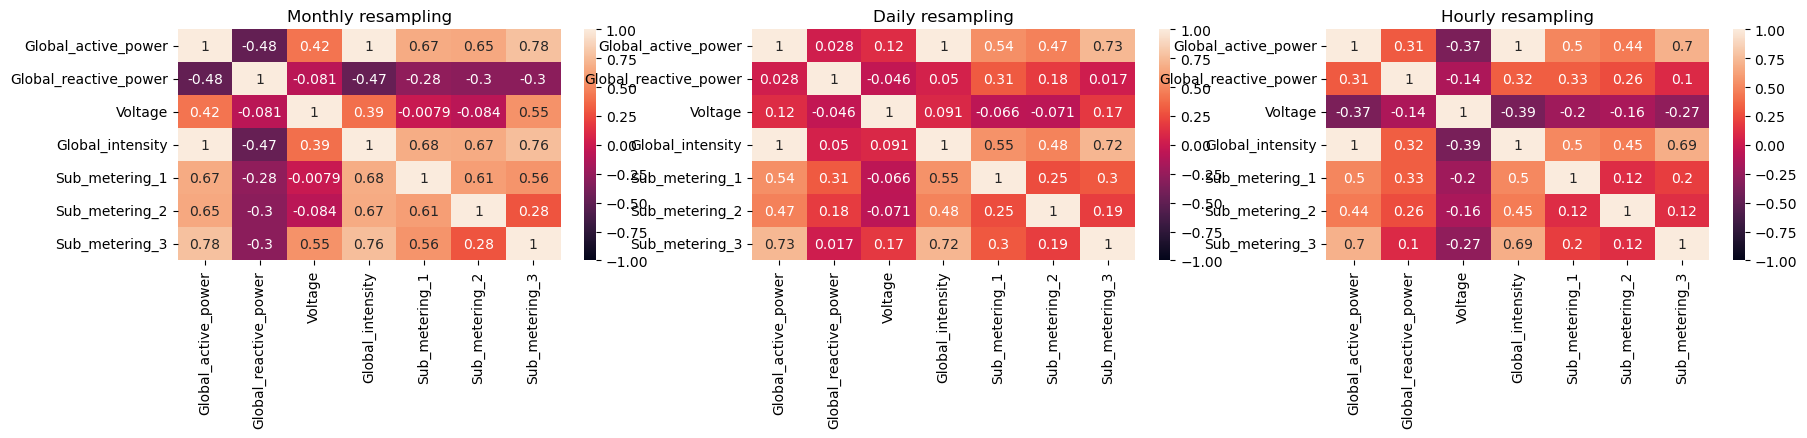

In [119]:
f= plt.figure(figsize=(21,3))

ax=f.add_subplot(131)
dfm = df.resample('M').mean()
sns.heatmap(dfm.corr(), vmin=-1, vmax=1, annot=True)
plt.title('Monthly resampling', size=12)

ax=f.add_subplot(132)
dfd = df.resample('D').mean()
sns.heatmap(dfd.corr(), vmin=-1, vmax=1, annot=True)
plt.title('Daily resampling', size=12)
  
ax=f.add_subplot(133)
dfh = df.resample('H').mean()
sns.heatmap(dfh.corr(), vmin=-1, vmax=1, annot=True)
plt.title('Hourly resampling', size=12)
plt.show()

It can be said that with resampling techniques one can change the correlations among features.

### Data Preparation

In [120]:
''' 
    Parameters:-
    n_in: Number of time steps to use as input (look-back).
    n_out: Number of time steps to predict into the future (forecast horizon).
    
'''

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)] 
        
        # putting it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [121]:
df_resample = df.resample('h').mean() 
df_resample.shape

(34589, 7)

By doing resampling over the hour, the size of data is reduced but it will keep the overall strucure of data as shown in the above.

In [122]:
df_resample.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


In [26]:
values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
s_df = series_to_supervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
s_df.drop(s_df.columns[r], axis=1, inplace=True)
s_df.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
0,0.545045,0.103358,0.335501,0.541487,0.0,0.144652,0.687748,0.636816
1,0.509006,0.110073,0.283802,0.502152,0.0,0.030869,0.680272,0.545045
2,0.488550,0.096987,0.315987,0.481110,0.0,0.000000,0.684350,0.509006
3,0.455597,0.099010,0.434417,0.449904,0.0,0.008973,0.702019,0.488550
4,0.322555,0.072536,0.495847,0.323529,0.0,0.002872,0.180772,0.455597


Above I showed 7 input variables (input series) and the 1 output variable for 'Global_active_power' at the current time in hour.

In [68]:
s_df.values.shape

(34588, 8)

In [27]:
# split into train and test sets
values = s_df.values

n_train_time = 365*24  #taking 1 year data for training. here, time step is 1 hour
train = values[:n_train_time, :]
test = values[n_train_time:, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

# I reshaped the input into the 3D format as it is expected by LSTMs [samples, timesteps, features].

(8760, 1, 7) (8760,) (25828, 1, 7) (25828,)


### Model Architecture

1) LSTM with 100 neurons in the first visible layer
3) dropout 20%
4) 1 neuron in the output layer for predicting Global_active_power.
5) The input shape will be 1 time step with 7 features.
6) I use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.
7) The model will be fit for 20 training epochs with a batch size of 70.

Epoch 1/20


2023-08-06 17:41:20.850102: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


126/126 - 2s - loss: 0.0190 - val_loss: 0.0114 - 2s/epoch - 14ms/step
Epoch 2/20
126/126 - 0s - loss: 0.0121 - val_loss: 0.0107 - 392ms/epoch - 3ms/step
Epoch 3/20
126/126 - 0s - loss: 0.0116 - val_loss: 0.0102 - 380ms/epoch - 3ms/step
Epoch 4/20
126/126 - 0s - loss: 0.0114 - val_loss: 0.0099 - 375ms/epoch - 3ms/step
Epoch 5/20
126/126 - 0s - loss: 0.0113 - val_loss: 0.0096 - 380ms/epoch - 3ms/step
Epoch 6/20
126/126 - 0s - loss: 0.0111 - val_loss: 0.0095 - 380ms/epoch - 3ms/step
Epoch 7/20
126/126 - 0s - loss: 0.0110 - val_loss: 0.0095 - 414ms/epoch - 3ms/step
Epoch 8/20
126/126 - 0s - loss: 0.0109 - val_loss: 0.0095 - 379ms/epoch - 3ms/step
Epoch 9/20
126/126 - 0s - loss: 0.0110 - val_loss: 0.0095 - 380ms/epoch - 3ms/step
Epoch 10/20
126/126 - 0s - loss: 0.0109 - val_loss: 0.0095 - 381ms/epoch - 3ms/step
Epoch 11/20
126/126 - 0s - loss: 0.0109 - val_loss: 0.0095 - 380ms/epoch - 3ms/step
Epoch 12/20
126/126 - 0s - loss: 0.0108 - val_loss: 0.0095 - 382ms/epoch - 3ms/step
Epoch 13/20
12

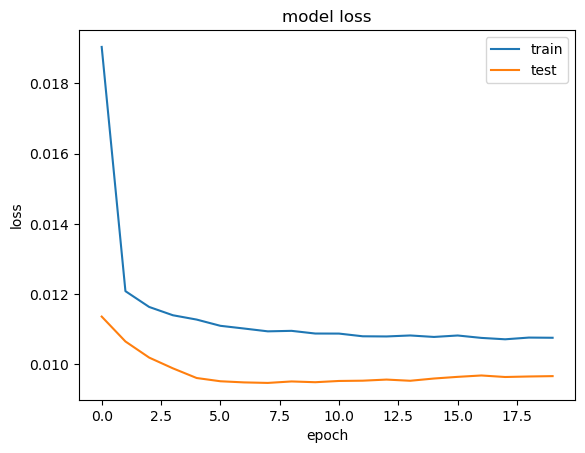

In [28]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [29]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = mean_squared_error(inv_y, inv_yhat, squared=False)
print('Test RMSE: %.3f' % rmse)

808/808 [==============================] - 1s 480us/step
Test RMSE: 0.633


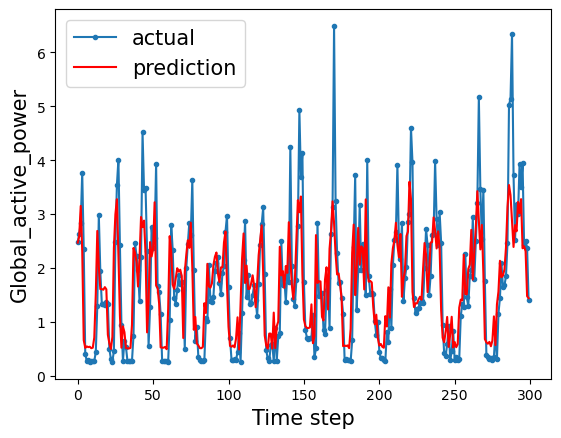

In [30]:
## for a demonstration purpose, I only compare the predictions in 300 hours. 

aa=[x for x in range(300)]
plt.plot(aa, inv_y[:300], marker='.', label="actual")
plt.plot(aa, inv_yhat[:300], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

## Vector Auto Regression model

In [124]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [125]:
# Define the start and end dates for training
start_date = df_resample.index[0]
end_date = start_date + pd.DateOffset(days=365)

# Select the target variable and input features
target_variable = 'Global_active_power'
input_features = ['Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

# Training data (1 year)
train_ar = df_resample[start_date:end_date]

# Testing data (remaining data)
test_ar = df_resample[end_date:]

# Prepare the training and testing data
train_X_ar = train_ar[input_features]
train_y_ar = train_ar[target_variable]

test_X_ar = test_ar[input_features]
test_y_ar = test_ar[target_variable]

In [132]:
# Perform the Augmented Dickey-Fuller (ADF) test
result = adfuller(train_y_ar, autolag='AIC')

# Extract and print the test results
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]
num_lags = result[2]
num_obs = result[3]

print(f'No. of lags used: {num_lags}')
print(f'No. of Observations used: {num_obs}')
print(f'ADF Statistic: {adf_statistic}')
print(f'P-value: {p_value}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')

# Check if the time series is stationary or not based on the p-value
if p_value <= 0.05:
    print("The time series is stationary (reject the null hypothesis of non-stationarity).")
else:
    print("The time series is non-stationary (fail to reject the null hypothesis of non-stationarity).")


No. of lags used: 37
No. of Observations used: 8723
ADF Statistic: -10.046938919955444
P-value: 1.4460973532021984e-17
Critical Values:
   1%: -3.431099882538333
   5%: -2.8618713981324873
   10%: -2.56694639826003
The time series is stationary (reject the null hypothesis of non-stationarity).


<Figure size 1200x600 with 0 Axes>

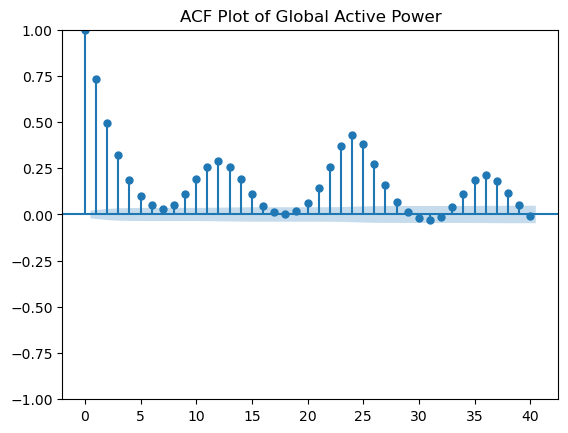

<Figure size 1200x600 with 0 Axes>

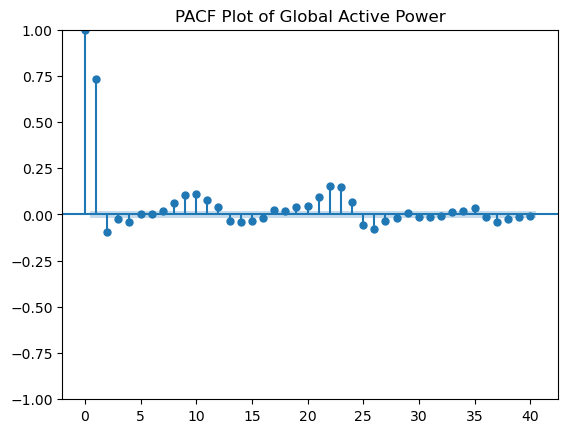

In [149]:
# Plot ACF and PACF for the target variable
plt.figure(figsize=(12, 6))
plot_acf(train_y_ar, lags=40, alpha=0.05)
plt.title('ACF Plot of Global Active Power')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(train_y_ar, lags=40, alpha=0.05)
plt.title('PACF Plot of Global Active Power')
plt.show()

In [161]:
# Find the best lag order using AIC
best_aic = np.inf
best_lag = None

for lag in range(1, 30):  
    model = VAR(train_ar)
    model_fitted = model.fit(lag)
    aic = model_fitted.aic
    if aic < best_aic:
        best_aic = aic
        best_lag = lag

print('Best Lag Order:', best_lag)

# Fit VAR model to training data with the best lag order
model = VAR(train_ar)
model_fitted = model.fit(best_lag)

# Forecast using the VAR model
forecast = model_fitted.forecast(train_ar.values[-best_lag:], steps=len(test_ar))

# Extract the 'Global_active_power' forecasted values
forecasted_global_active_power = forecast[:, df_resample.columns.get_loc(target_variable)]

# Calculate RMSE to evaluate the model's performance
rmse = mean_squared_error(test_y_ar, forecasted_global_active_power, squared=False)
print('VAR Model Test RMSE:', rmse)


Best Lag Order: 27
VAR Model Test RMSE: 0.8516534726736336


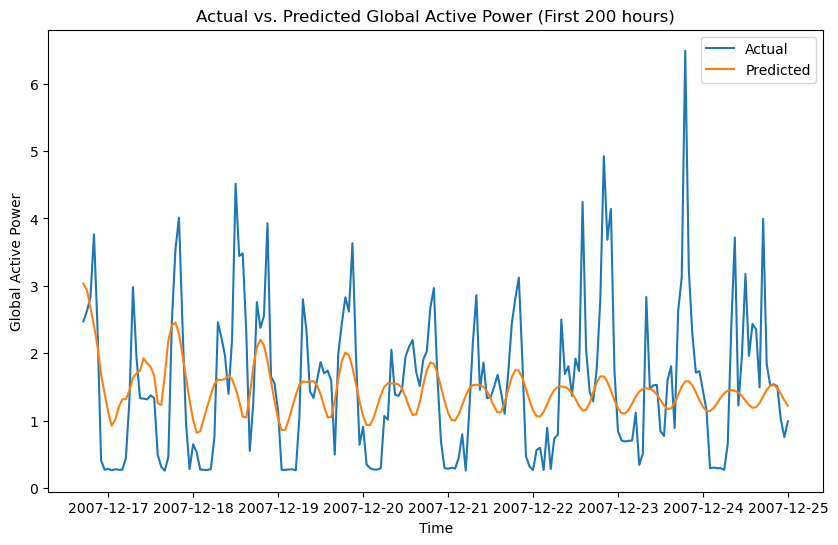

In [162]:
# Plot the comparison over 200 hours
plot_hours = 200
plt.figure(figsize=(10, 6))
plt.plot(test_y_ar.index[:plot_hours], test_y_ar[:plot_hours], label='Actual')
plt.plot(test_y_ar.index[:plot_hours], forecasted_global_active_power[:plot_hours], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Global Active Power')
plt.title('Actual vs. Predicted Global Active Power (First 200 hours)')
plt.legend()
plt.show()